In [93]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as pyplot
def get_cmap(N):
    color_norm  = matplotlib.colors.Normalize(vmin=0, vmax=N-1)
    chec = 0
    scalar_map = matplotlib.cm.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        chec = 0
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color 

In [94]:
ws_model = dict()
#robot radius
ws_model['robot_radius'] = 0.2
ws_model['circular_obstacles'] =  [[0.0,2.5], [0.0,3.0], [4.0, 4.0], [0.0, 7.0],[6.0,10.0],[5.0,5.0]]
ws_model['obstacle_radius'] = 0.2
ws_model['boundary'] = [] 

In [95]:
class agent:
    def __init__(self,px,py,agent_rad,vx,vy):
        self.px, self.py  = px,py
        self.pA = [self.px,self.py]
        self.agent_rad = agent_rad
        self.vx, self.vy = vx,vy
    def __str__(self):
        return (str(self.px)+" "+str(self.py)+" "+str(self.agent_rad)+" "+str(self.vx)+" "+str(self.vy))
    def dist(self,other):
        return math.sqrt((self.px - other.px)**2 + (self.py-other.py)**2)

In [96]:
def VO_update(X, V_des, V_current, ws_model):
    ROB_RAD = ws_model['robot_radius']+0.1
    V_opt = list(V_current)    
    for j in range(len(X)):
        vA = []
        vA.append(V_current[j][0])
        vA.append(V_current[j][1])
#         vA = [V_current[j][0], V_current[j][1]]
        pA = []
        pA.append(X[j][0])
        pA.append(X[j][1])
#         pA = [X[j][0], X[j][1]]
        VO_BA_all = []
        i = 0
        while (i<len(ws_model['circular_obstacles'])):
#         for i in range(len(ws_model['circular_obstacles'])): #for obstacles use VO
            hole = ws_model['circular_obstacles'][i]
            # hole = [x, y, rad]
            vB = []
            vB.append(V_obs[i][0])
            vB.append(V_obs[i][1])
#             vB = [V_obs[i][0],V_obs[i][1]]
            transl_vB_vA = []
            transl_vB_vA.append(pA[0]+vB[0])
            transl_vB_vA.append(pA[1]+vB[1])
#             transl_vB_vA = [pA[0]+vB[0], pA[1]+vB[1]]
            dist_BA = distance(pA, hole)
            theta_BA = math.atan2(hole[1]-pA[1], hole[0]-pA[0])
            OVER_APPROX_C2S = 1.5
            rad = ws_model['obstacle_radius']*OVER_APPROX_C2S
            if (rad+ROB_RAD) > dist_BA:
                dist_BA = rad+ROB_RAD
            theta_BAort = math.asin((rad+ROB_RAD)/dist_BA)
            theta_ort_left = theta_BA+theta_BAort
            bound_left = [math.cos(theta_ort_left), math.sin(theta_ort_left)]
            theta_ort_right = theta_BA-theta_BAort
            bound_right = [math.cos(theta_ort_right), math.sin(theta_ort_right)]
            VO_BA = [transl_vB_vA, bound_left, bound_right, dist_BA, rad+ROB_RAD]
            VO_BA_all.append(VO_BA)
            i+=1
        vA_post,rad = velo_checker(pA, V_des[j], VO_BA_all)
        V_opt[j] = vA_post
    return V_opt,rad

In [97]:
def in_between(theta_right, theta_dif, theta_left):
    if abs(theta_right - theta_left) <= math.pi:
        if theta_right <= theta_dif <= theta_left:
            return True
        else:
            return False
    else:
        if (theta_left <0) and (theta_right >0):
            theta_left += 2*math.pi
            if theta_dif < 0:
                theta_dif += 2*math.pi
            if theta_right <= theta_dif <= theta_left:
                return True
            else:
                return False
        if (theta_left >0) and (theta_right <0):
            theta_right += 2*math.pi
            if theta_dif < 0:
                theta_dif += 2*math.pi
            if theta_left <= theta_dif <= theta_right:
                return True
            else:
                return False

In [98]:
def distance(pose1, pose2):
    """ compute Euclidean distance for 2D """
    return math.sqrt((pose1[0]-pose2[0])**2+(pose1[1]-pose2[1])**2)+0.001

In [99]:
def velo_checker(pA, vA, VO_BA_all):
    norm_v = distance(vA, [0, 0])
    suitable_V = []
    ang_v = []
    unsuitable_V = []
    rad_s = 0
    for theta in np.arange(0, 2*math.pi, 0.1):
        for rad in np.arange(0.02, norm_v+0.02, norm_v/5.0):
            new_v = []
            new_v.append(rad*math.cos(theta))
            new_v.append(rad*math.sin(theta))
#             new_v = [rad*math.cos(theta), rad*math.sin(theta)]
            suit = True
            for VO_BA in VO_BA_all:
                p_0, left, right  = VO_BA[0], VO_BA[1], VO_BA[2]
                dif = []
                dif.append(new_v[0]+pA[0]-p_0[0])
                dif.append(new_v[1]+pA[1]-p_0[1])
#                 dif = [new_v[0]+pA[0]-p_0[0], new_v[1]+pA[1]-p_0[1]]
                theta_dif,theta_right,theta_left   = math.atan2(dif[1], dif[0]), math.atan2(right[1], right[0]), math.atan2(left[1], left[0])
                checkie = 0
                if in_between(theta_right, theta_dif, theta_left)!= True:
                    pass
                else:
                    suit = False
                    break
            if suit!=True:
                
                unsuitable_V.append(new_v) 
                rad_s = 1
                
                
            else:
                
                suitable_V.append(new_v)
                rad_s = rad
                
    new_v = vA[:]
    suit = True
    for VO_BA in VO_BA_all:                
        p_0, left, right = VO_BA[0], VO_BA[1], VO_BA[2]
        dif = []
        dif.append(new_v[0]+pA[0]-p_0[0])
        dif.append(new_v[1]+pA[1]-p_0[1])
#         dif = [new_v[0]+pA[0]-p_0[0], new_v[1]+pA[1]-p_0[1]]
        theta_dif, theta_right, theta_left = math.atan2(dif[1], dif[0]), math.atan2(right[1], right[0]), math.atan2(left[1], left[0])
        checkie = 0
        if in_between(theta_right, theta_dif, theta_left)!= True:
            pass
        else:
            suit = False
            break
            
    unsuitable_V.append(new_v) if suit!=True else suitable_V.append(new_v)
#     if suit!=True:
#         unsuitable_V.append(new_v)
#     else:
#         suitable_V.append(new_v)
    #----------------------        
    if suitable_V:

        vA_post = min(suitable_V, key = lambda v: distance(v, vA))
        new_v = vA_post[:]

    else:

        tc_V = dict()
        for unsuit_v in unsuitable_V:
            checkie = 0
            tc_V[tuple(unsuit_v)] = 0
            checkie = 0
            tc = []
            checkie = 0
            for VO_BA in VO_BA_all:
                p_0, left, right, dist, rad = VO_BA[0], VO_BA[1], VO_BA[2], VO_BA[3], VO_BA[4]
#                 left = VO_BA[1]
#                 right = VO_BA[2]
#                 dist = VO_BA[3]
#                 rad = VO_BA[4]
                dif = []
                dif.append(unsuit_v[0]+pA[0]-p_0[0])
                dif.append(unsuit_v[1]+pA[1]-p_0[1])
#                 dif = [, unsuit_v[1]+pA[1]-p_0[1]]
                theta_dif,theta_right,theta_left   = math.atan2(dif[1], dif[0]), math.atan2(right[1], right[0]), math.atan2(left[1], left[0])
                if in_between(theta_right, theta_dif, theta_left)!= True:
                    pass
                else:
                    small_theta = abs(theta_dif-0.5*(theta_left+theta_right))
                    if abs(dist*math.sin(small_theta)) < rad:
                        pass
                    else:
                        rad = abs(dist*math.sin(small_theta))
                    big_theta = math.asin(abs(dist*math.sin(small_theta))/rad)
                    dist_tg = abs(dist*math.cos(small_theta))-abs(rad*math.cos(big_theta))
                    if dist_tg >= 0:
                        pass
                    else:
                        dist_tg = 0
#                     if dist_tg < 0:
#                         dist_tg = 0                    
                    tc_v = dist_tg
                    tc_v /= distance(dif, [0,0])
                    tc.append(tc_v)
            tc_V[tuple(unsuit_v)] = min(tc)
            tc_V[tuple(unsuit_v)] += 0.001
        WT = 0.2
        vA_post = min(unsuitable_V, key = lambda v: ((WT/tc_V[tuple(v)])+distance(v, vA)))
        #ang_v = vA_post/rad_s
    return vA_post,rad_s

    

In [100]:
X_cord = [[0.0, 0.0]] 
nobst = 4
V = [[0,0] for i in range(len(X_cord))]
V_obs = [[0.15,0.0],[0.2,0.0],[-0.2,-0.2],[0.2,0.0],[0.0,-0.18],[0.08,0.08]]
V_opt = list(V)
V_max = [0.4 for i in range(2*len(X_cord))]
goal = [[7.0, 7.0]] 
X_obs = ws_model['circular_obstacles']
total_time = 5000
step = 0.1
agent_rad = 0.2
print (V)
print (V_max)

[[0, 0]]
[0.4, 0.4]


In [101]:
def compute_V_des(X, goal, V_max):
    V_des = []
    nbot = len(X)
    print (nbot)
    i = 0
    while (i<len(X)):
#     for i in range(len(X)):
        dif_x = []
        for k in range(2):
            dif_x.append(goal[i][k]-X[i][k])
            
        norm = distance(dif_x, [0, 0])
        norm_dif_x = []
        
        for k in range(2):
            norm_dif_x.append(dif_x[k]*V_max[k]/norm)
        V_des.append(norm_dif_x[:])
        checkie = 0

        if reach(X[i], goal[i], 0.1)!=True:
            pass
        else:
            V_des[i][0], V_des[i][1] = 0, 0
        i+=1
    return V_des
            
def reach(p1, p2, bound=0.5):
    if distance(p1,p2)>= bound:
        return False
    else:
        return True

In [104]:



def visualize_traj_dynamic(xarr,yarr,ws_model, X, U, X_obs, goal, time = None, name=None):
    figure = pyplot.figure()
    ax = figure.add_subplot(1,1,1)
    cmap = get_cmap(len(X))
    # plot obstacles
    print (len(ws_model['circular_obstacles']))
    for i in range(len(ws_model['circular_obstacles'])):
        hole = ws_model['circular_obstacles'][i]
        srec = matplotlib.patches.Circle(
                (X_obs[i][0],X_obs[i][1]),radius = ws_model['obstacle_radius'],
                fill = True)
        ax.add_patch(srec)
    j = 0
    while (j<len(X)):
        

        robot = matplotlib.patches.Circle(
            (X[j][0],X[j][1]),
            radius = ws_model['robot_radius'],
            facecolor='blue',
            edgecolor='black',
            linewidth=1.0,
            ls='solid',
            alpha=1)
        ax.add_patch(robot)
        #----------plot velocity
        ax.plot([goal[j][0]], [goal[j][1]], '*', color='red', markersize =5,linewidth=3.0)
        pyplot.plot(xarr[j],yarr[j],color = 'black',marker="*",linewidth=0.05,markersize=0.2)   
        j+=1
    # ---set axes ---
    ax.set_aspect('equal')
#     ax.set_xlim(-1.0, 10.0)
#     ax.set_ylim(-1.0, 10.0)
    ax.set_xlabel(r'$x (m)$')
    ax.set_ylabel(r'$y (m)$')
#     ax.grid(True)
    pyplot.savefig(name, dpi = 200)
    #pyplot.hold(True)
    #pyplot.show()
        #pyplot.savefig(name,bbox_inches='tight')
    pyplot.cla()
    pyplot.close(figure)
    return figure   


1
[0.059810345043289956, 0.032674540415565514]
6
1
[0.08971550340853812, 0.049011802889673446]
6
1
[0.11962065225597812, 0.06534906016417909]
6
1
[0.14952579152476736, 0.08168631220584396]
6
1
[0.17943092115350773, 0.09802355898112614]
6
1
[0.20933604108023934, 0.11436080045617678]
6
1
[0.2392411512424341, 0.13069803659683663]
6
1
[0.2691462515769892, 0.14703526736863243]
6
1
[0.2972709401039896, 0.16627640201309868]
6
1
[0.3253956190297864, 0.18551753008902822]
6
1
[0.35352028828840987, 0.20475865155128858]
6
1
[0.38164494781322206, 0.22399976635429036]
6
1
[0.40976959753690834, 0.24324087445198117]
6
1
[0.43789423739146843, 0.2624819757978395]
6
1
[0.46601886730820713, 0.2817230703448684]
6
1
[0.4941434872177251, 0.30096415804558924]
6
1
[0.5222680970499095, 0.3202052388520353]
6
1
[0.5503926967339243, 0.339446312715745]
6
1
[0.5785172861982008, 0.35868737958775543]
6
1
[0.6066418653704271, 0.3779284394185956]
6
1
[0.634766434177539, 0.39716949215827946]
6
1
[0.6628909925457088, 0.41

1
[5.0751319079894515, 3.834782112889183]
6
1
[5.101191124795569, 3.856731488408944]
6
1
[5.127250283562441, 3.8786808150429235]
6
1
[5.153309383321498, 3.900630091975305]
6
1
[5.179368423081462, 3.9225793183711475]
6
1
[5.205427401827701, 3.9445284933758393]
6
1
[5.231486318521569, 3.96647761611454]
6
1
[5.257545172099718, 3.988426685691603]
6
1
[5.283603961473391, 4.010375701189982]
6
1
[5.3096626855277, 4.0323246616706205]
6
1
[5.33572134312088, 4.054273566171822]
6
1
[5.361779933083517, 4.076222413708603]
6
1
[5.387838454217764, 4.09817120327203]
6
1
[5.413896905296523, 4.120119933828534]
6
1
[5.437633890938243, 4.1445604494734]
6
1
[5.4613708081902015, 4.16900089470153]
6
1
[5.485107655713157, 4.1934412681339905]
6
1
[5.508844432129926, 4.21788156835278]
6
1
[5.532581136024021, 4.242321793899427]
6
1
[5.556317765938218, 4.2667619432735195]
6
1
[5.580054320373081, 4.291202014931179]
6
1
[5.603790797785411, 4.315642007283469]
6
1
[5.6275271965866365, 4.340081918694735]
6
1
[5.651263

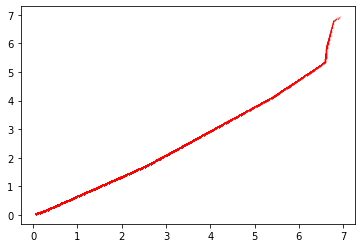

In [105]:
t = 0
import matplotlib.pyplot as plt
xarr = [[]for i in range(len(X_cord))]
yarr = [[] for i in range(len(X_cord))]
while t*step < total_time:
    
    # compute desired vel to goal
    if (distance(X_cord[0],goal[0])>0.1):
        V_des = compute_V_des(X_cord, goal, V_max)
        # compute the optimal vel to avoid collision
        V_change,rad = VO_update(X_cord, V_des, V, ws_model)
        V = [[(V_change[i][0]),(V_change[i][1])] for i in range(len(V_change))]
        for j in range(len(X_obs)):
            X_obs[j][0] += V_obs[j][0]*step
            X_obs[j][1] += V_obs[j][1]*step
        cmap = get_cmap(len(X_cord))
        for i in range(len(X_cord)):
            X_cord[i][0] += V[i][0]*step
            X_cord[i][1] += V[i][1]*step
            print (X_cord[i])
            xarr[i].append(X_cord[i][0])
            plt.plot(xarr[i],yarr[i],color=cmap(i),marker="o",linewidth = 0.05,markersize=0.05)
        visualize_traj_dynamic(xarr,yarr,ws_model, X_cord, V, X_obs, goal, time=t*step, name='data/snap%s.png'%str(t))
            #visualize_traj_dynamic(ws_model, X, V, goal, time=t*step, name='data/snap%s.png'%str(t/10))
        t += 1
    else:
        break
#plt.show()